# Modelling 
Recall that our modelling problem is one of binary classification. Namely, given our dataset of student's performance in math courses, we wish to predict whether or not a student will graduate within 4 years.

We will try our luck with four models in total:
1. **Logistic regression**: This can be considered our baseline model.

2. **Support Vector Classifier with Radial Basis Function**: This will separate our data along more complex decision boundaries to capture non-linearity that is missed by logistic regression.

3. **XGBoost Classifier**: The use of gradient boosting will help this model learn subtler aspects that may be missed by the previous two.

4. **Custom Stacked Classifier**: This is a customized ensemble classifier which uses prediction probabilities from our previously fitted SVC and XGB classifiers as features for a logistic regression model.

Below, we start as usual by loading the necessary libraries and the dataset with engineered features that was created in the EDA notebook.

In [209]:
# #import data handling libraries
import pandas as pd
import numpy as np
import json

import modeller

# Automatically reload all modules
%load_ext autoreload
%autoreload 2  

#load the dictionaries
with open ('../Data/Dictionaries/crse_dict.json') as f:
    crse_dict = json.load(f)
with open ('../Data/Dictionaries/math_dict.json') as f:
    math_dict = json.load(f)
with open ('../Data/Dictionaries/gen_dict.json') as f:
    gen_dict = json.load(f)

#make the course lists
courses = list(crse_dict.keys())
math_courses = list(math_dict.keys())
gen_courses = list(gen_dict.keys())

#read in the main dataset
df = pd.read_csv('../Data/Datasets/dataset_engineered.csv')

df.sample(5)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,STUDENT,ENT_SEM,GRAD_SEM,165,166,265,143,140,104,150,...,SEM_8.0_GEN_cdf,SEM_8.5_GEN_cdf,SEM_9.0_GEN_cdf,SEM_9.5_GEN_cdf,SLOPE,INT,SLOPE_MATH,INT_MATH,SLOPE_GEN,INT_GEN
7384,10551,19.6,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,...,1,1,1,1,0.154386,-3.508772e-01,0.0,0.0,0.154386,-3.508772e-01
1789,2584,17.6,9.5,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,1,1,1,1,0.084211,4.210526e-01,0.0,0.0,0.084211,4.210526e-01
2960,4232,18.6,9.5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1,1,1,1,0.031579,7.894737e-01,0.0,0.0,0.031579,7.894737e-01
7428,10619,16.6,9.5,0.0,0.0,0.0,0.0,0.0,0.0,3.5,...,1,1,1,1,0.136842,-5.444869e-17,0.0,0.0,0.136842,-5.444869e-17
6297,8987,20.0,8.5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1,1,1,1,0.031579,7.894737e-01,0.0,0.0,0.031579,7.894737e-01


In [ ]:
df.columns

Index(['STUDENT', 'ENT_SEM', 'GRAD_SEM', '165', '166', '265', '143', '140',
       '104', '150', '207', '201', '317', '267', '105', '301', '266', '414',
       '160', '101', '25', '492', '341', '385', '435', '397', '436', '495',
       '314', '500', '304', 'Y', 'TM', 'SEM_0.5_cdf', 'SEM_1.0_cdf',
       'SEM_1.5_cdf', 'SEM_2.0_cdf', 'SEM_2.5_cdf', 'SEM_3.0_cdf',
       'SEM_3.5_cdf', 'SEM_4.0_cdf', 'SEM_4.5_cdf', 'SEM_5.0_cdf',
       'SEM_5.5_cdf', 'SEM_6.0_cdf', 'SEM_6.5_cdf', 'SEM_7.0_cdf',
       'SEM_7.5_cdf', 'SEM_8.0_cdf', 'SEM_8.5_cdf', 'SEM_9.0_cdf',
       'SEM_9.5_cdf', 'SEM_0.5_MATH_cdf', 'SEM_1.0_MATH_cdf',
       'SEM_1.5_MATH_cdf', 'SEM_2.0_MATH_cdf', 'SEM_2.5_MATH_cdf',
       'SEM_3.0_MATH_cdf', 'SEM_3.5_MATH_cdf', 'SEM_4.0_MATH_cdf',
       'SEM_4.5_MATH_cdf', 'SEM_5.0_MATH_cdf', 'SEM_5.5_MATH_cdf',
       'SEM_6.0_MATH_cdf', 'SEM_6.5_MATH_cdf', 'SEM_7.0_MATH_cdf',
       'SEM_7.5_MATH_cdf', 'SEM_8.0_MATH_cdf', 'SEM_8.5_MATH_cdf',
       'SEM_9.0_MATH_cdf', 'SEM_9.5_M

Recall:
- The column `TM` stands for "Took a math-major-course". Since these number around 1200 (out of around 9000 students in our dataset), we will stratify by `TM` when we carry out our train-test split.
- We count Fall and Spring as full semesters, and Summer as a half-semester; thus, our target variable `Y` equals 1 if the student graduates in 9.5 semester (the typical case if they enroll in fall and graduate in spring of their fourth year), and 0 otherwise.
- The columns with 3-digit numbers are the courses. Recall from the data cleaning notebook that their values are computed as $\pm 1$ times the semester the course was taken, where $1$ corresponds to 'ABOVE C-' or 'Satisfactory/pass', and $-1$ corresponds to 'C- OR BELOW'.
- The columns `SEM_i_cdf`, `SEM_i_MATH_cdf`, and `SEM_i_GEN_cdf` are integer-valued and measure the students' cumulative performance in the `i`-th semester in all math courses, math-major specific courses, and general math courses, respectively. (See the EDA notebook for more details on how they are computed).
- The last few features are the slopes and intercepts of certain lines of best fit computed to capture each students "performance trend" across 4 years in all math courses, math-major courses, and general math courses, respectively. (See the Feature Engineering portion of the EDA notebook for more details.)

Our full list of features will consist of all these variables, including `ENT_SEM`, which records the semester in which the student enrolled. 

In [212]:
courses = ['165', '166', '265', '143', '140',
       '104', '150', '207', '201', '317', '267', '105', '301', '266', '414',
       '160', '101', '25', '492', '341', '385', '435', '397', '436', '495',
       '314', '500', '304']
SEMs = ['ENT_SEM', 'SEM_0.5_cdf', 'SEM_1.0_cdf',
       'SEM_1.5_cdf', 'SEM_2.0_cdf', 'SEM_2.5_cdf', 'SEM_3.0_cdf',
       'SEM_3.5_cdf', 'SEM_4.0_cdf', 'SEM_4.5_cdf', 'SEM_5.0_cdf',
       'SEM_5.5_cdf', 'SEM_6.0_cdf', 'SEM_6.5_cdf', 'SEM_7.0_cdf',
       'SEM_7.5_cdf', 'SEM_8.0_cdf', 'SEM_8.5_cdf', 'SEM_9.0_cdf',
       'SEM_9.5_cdf', 'SEM_0.5_MATH_cdf', 'SEM_1.0_MATH_cdf',
       'SEM_1.5_MATH_cdf', 'SEM_2.0_MATH_cdf', 'SEM_2.5_MATH_cdf',
       'SEM_3.0_MATH_cdf', 'SEM_3.5_MATH_cdf', 'SEM_4.0_MATH_cdf',
       'SEM_4.5_MATH_cdf', 'SEM_5.0_MATH_cdf', 'SEM_5.5_MATH_cdf',
       'SEM_6.0_MATH_cdf', 'SEM_6.5_MATH_cdf', 'SEM_7.0_MATH_cdf',
       'SEM_7.5_MATH_cdf', 'SEM_8.0_MATH_cdf', 'SEM_8.5_MATH_cdf',
       'SEM_9.0_MATH_cdf', 'SEM_9.5_MATH_cdf']
conts = ['SLOPE', 'INT', 'SLOPE_MATH', 'INT_MATH', 'SLOPE_GEN', 'INT_GEN']
full_features = conts + courses + SEMs

print('Number of features:', len(full_features))

print(f'Overall grad rate: {df['Y'].mean()*100:.2f}%')

#random states to be used for cross-validation and all other random processes
random_states = [5917, 656, 4125, 2797, 9936]
print('Random states:', random_states)

Number of features: 73
Overall grad rate: 48.97%
Random states: [5917, 656, 4125, 2797, 9936]


To start, we will create 5 train-test splits of our dataset, each time using an entry in `random_states`, and stratifying by `TM` to preserve the proportion of students that took a math-major course. 

Each split will be used for cross-validation and model training; we do this so as to minimize the chance of overfit/underfit which may arise by virtue of some quirk in one particular split.

In [ ]:
splits = modeller.get_splits(data=df,features = full_features,strat_variable='TM')

### Model 1: Logistic regression
Below, we train the logistic regression models (note: there will be one model for each of our five train-test splits). We use a Grid Search CV with an $L2$-penalty to simultaneously fit our models as well as tune the hyperparameter `C` (which controls the amount of regularization).

In [ ]:
logreg_models, logreg_df, logreg_fimp_df = modeller.logreg_cv(splits=splits)
print('Accuracies for logistic regression models:')
logreg_df

,cv_accuracy,test_accuracy,accuracy_change
0,0.630586,0.620577,-0.010009
1,0.629766,0.638541,0.008775
2,0.631264,0.634186,0.002922
3,0.633034,0.611867,-0.021167
4,0.629221,0.616766,-0.012455


The accuracy scores are not great, but at least there does not appear to be an issue with overfitting or underfitting, since the change in accuracy from train to test sets is relatively small.

Next, let's plot the coefficients of the model, ordered by mean absolute value across all 5 splits. (Note: this serves a measure of feature importance for logistic regression models.)

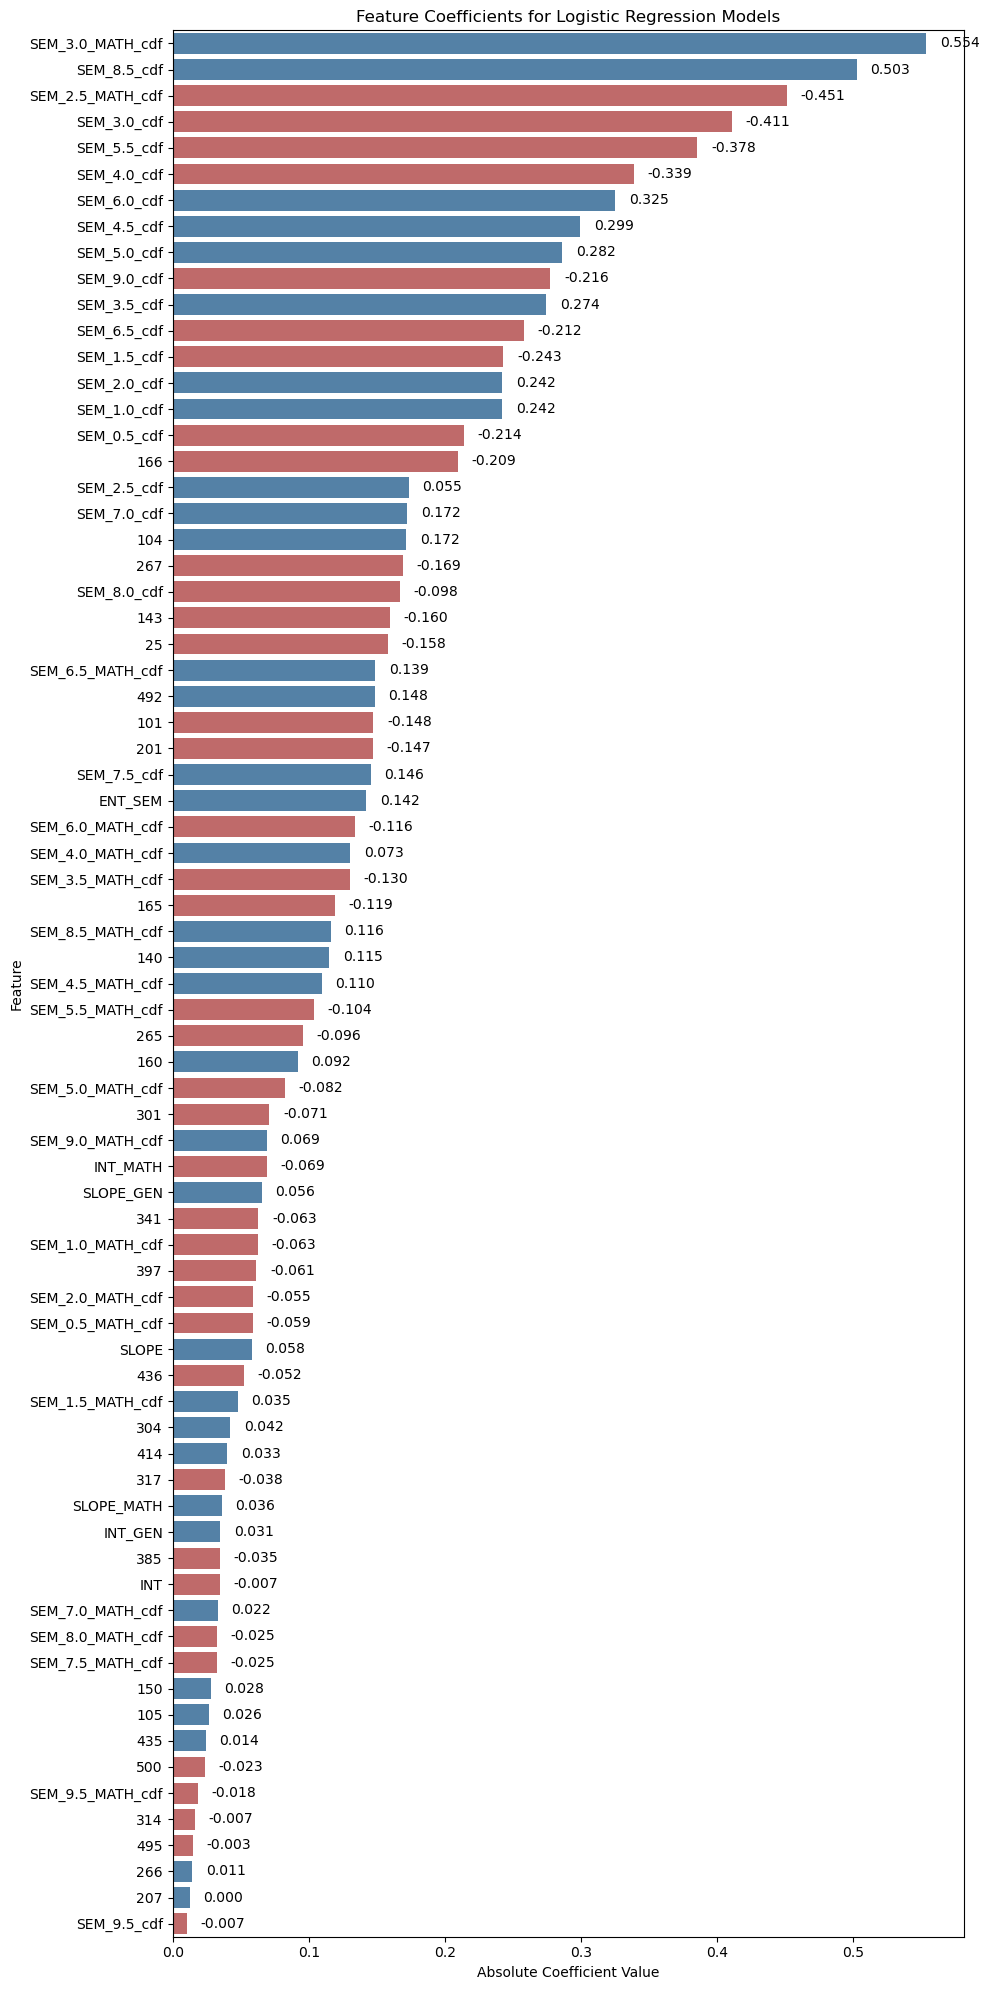

In [221]:
modeller.logreg_plot_fimp(logreg_fimp_df,save=True)

Observations:
- Interestingly, the logistic regression doesn't appear to care much about the course columns, since the coefficients for the cumulative performance columns dominate the top of the list.
- The mix of positive and negative coefficients near the top are somewhat mysterious. For instance, it would appear that having a higher cumulative performance in Semester 6 increases the probability of `Y` = 1, whereas having a higher cumulative performance in Semester 3 decreases it!

    One possible reason for this mix could be that by varying the positive and negative coefficients, the model is attempting to approximate how the joint (i.e. simultaneous) distribution of the cumulative performance across the semesters affects `Y`.

### Model 2: XGBoost
Below, we train the XGBoost models (one for each split). This time, we use a Randomized Search CV to simultaneously tune the various hyperparameters available for XGBoost and fit the models to the training sets. 

In [ ]:
xgb_models, xgb_df, xgb_fimp_df = modeller.xgb_cv(splits=splits)
print('Accuracies for XGBoost models:')
xgb_df

Accuracies for XGBoost models:


,cv_accuracy,test_accuracy,accuracy_change
0,0.661360,0.658138,-0.003222
1,0.662174,0.661949,-0.000225
2,0.668847,0.661404,-0.007442
3,0.670208,0.639085,-0.031123
4,0.662443,0.664671,0.002228


This is certainly an improvement on the logistic regression! Aside from split 3, it appears that the models are neither overfit nor underfit. 

Below, we display the feature importances, ordered by mean "total information gain" across all 5 splits, and normalized so that they add up to 100.

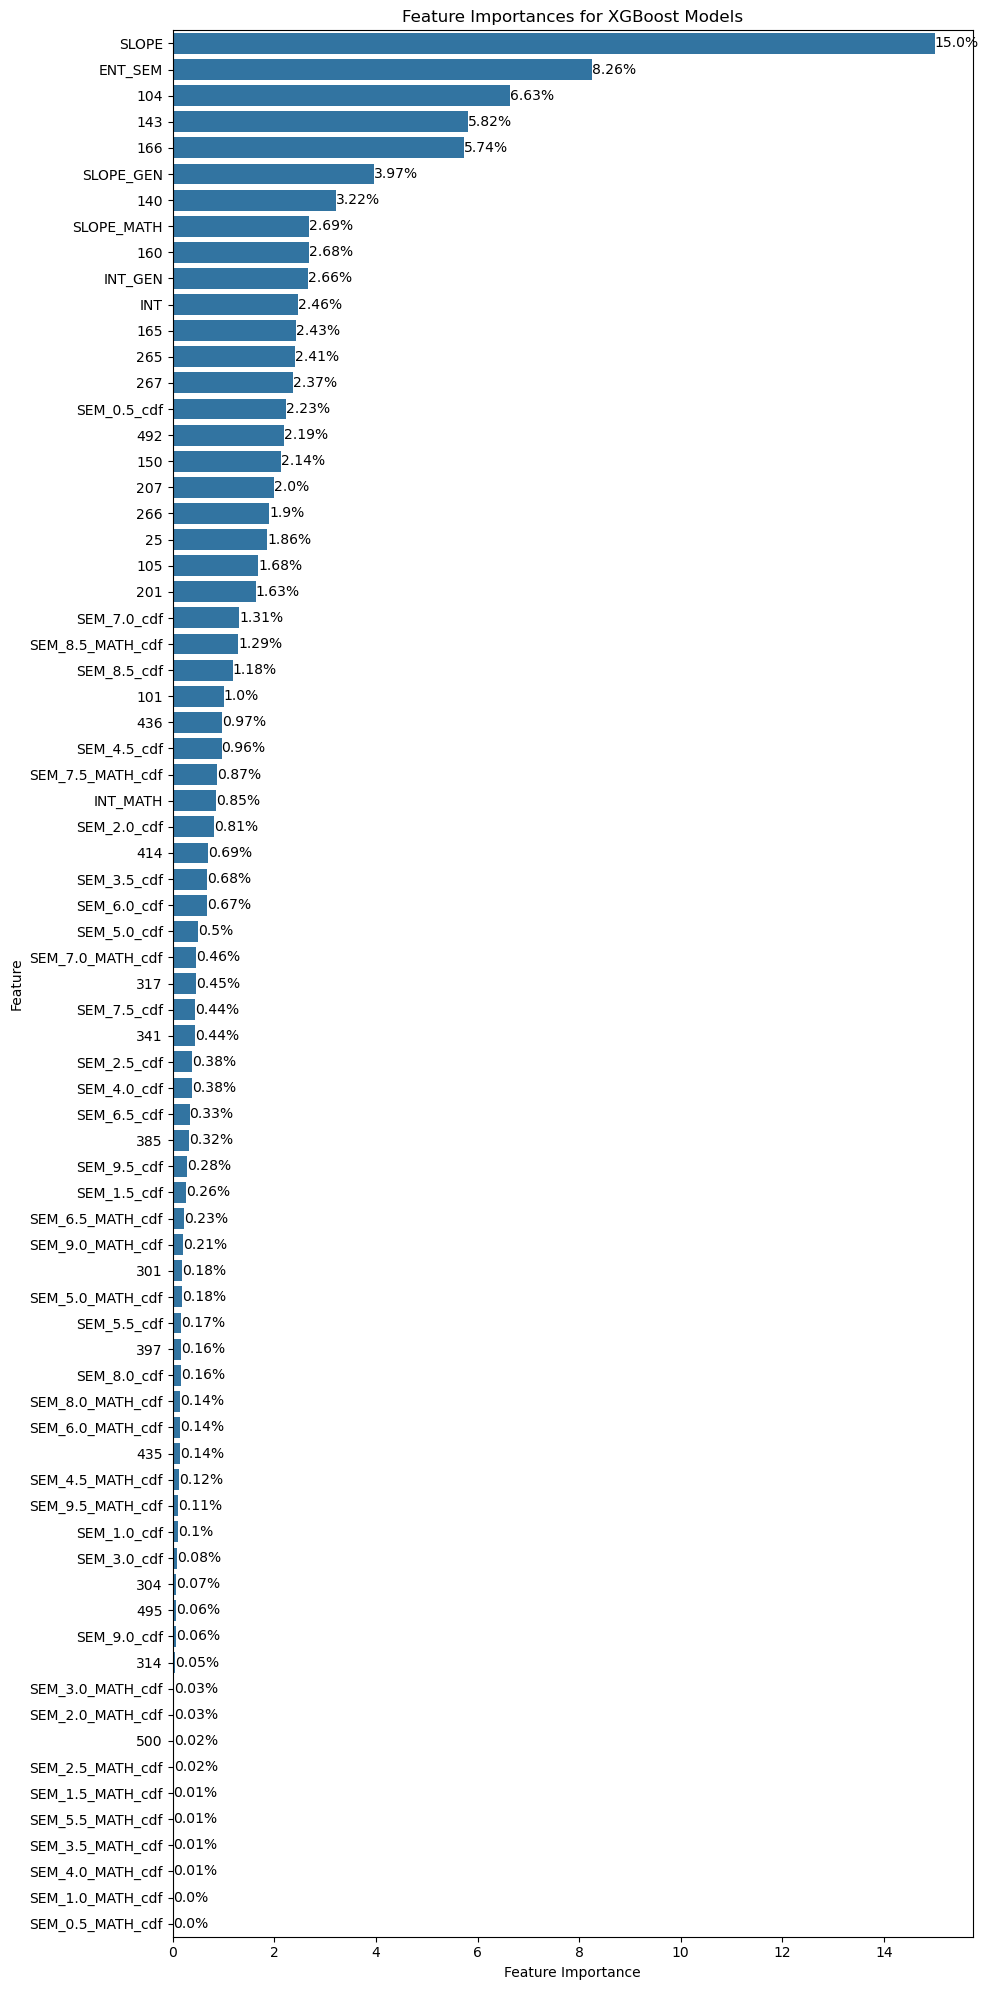

In [227]:
modeller.xgb_plot_fimp(xgb_fimp_df,save=True)

Observations:
- We can see that the features that were important to XGBoost are quite different from those important to Logistic regression. In particular, the top few features are heavily populated with courses, with the top 3 being 104 (INTRO TO PROBABILITY), 143 (PREP FOR CALCULUS) and 166 (CALCULUS II).
- By a wide margin, the most important feature is `SLOPE`, which measures the rate-of-change of the students' cumulative performance as the semesters increase. 
- It is striking (and somewhat mysterious) that the entry semester of the student (`ENT_SEM`) is the second-most important feature. This might be because the distributions of the values changed/became unusual from 2020 onwards due to COVID, which the model is picking up on. 

### Model 3: Support Vector Classifier with Radial Basis Functions

Below, we train the SVC with RBF models for each split using 5-fold Cross-validation. We omit any hyperparameter tuning because radial basis functions are computationally very expensive.

In [232]:
svc_models, svc_df = modeller.svc_rbf_cv(splits=splits)
print('Accuracies for SVC models:')
svc_df

Accuracies for SVC models:


,cv_accuracy,test_accuracy,accuracy_change
0,0.647744,0.640174,-0.007570
1,0.650056,0.648884,-0.001172
2,0.645834,0.656505,0.010671
3,0.654551,0.623843,-0.030707
4,0.645014,0.657050,0.012036


Observations:
As we can see, the SVC models perform better than the logistic regression but not as well as XGBoost (although this is perhaps not saying much, since the accuracies of all the models are within 5% of each other). 

### Model 4: Stacked Classifier
Our custom binary classifier is designed as follows (for each split):
1. Use the fitted SVC and XGBoost models generated above to get vectors of predicted class probabilities on the train and test sets.  
2. Use these probabilities for the train sets as features to fit a logistic regression model.
3. Use the fitted logistic regression to make predictions on the test set.

Below, we run our custom classifier and display the accuracy scores.

In [234]:
stacked_classifiers, stacked_df = modeller.stacked_classifier(splits=splits,
                                                             xgb_models=xgb_models,
                                                             svc_models=svc_models)
print('Accuracies for stacked classifier:')
stacked_df

Accuracies for stacked classifier:


,cv_accuracy,test_accuracy,accuracy_change
0,0.714188,0.653239,-0.060949
1,0.685458,0.665759,-0.019698
2,0.690768,0.662493,-0.028275
3,0.700300,0.639085,-0.061214
4,0.682870,0.668481,-0.014389


Observations: 
The test accuracies for the stacked classifier are almost identical to those of XGBoost, so it has not accomplished much. 

If anything, it is to be considered less trustworthy than the XGBoost model because it is showing considerable improvements in the train accuracy, suggesting that it is overfit compared to the other models! (See the table below)

Before formally stating the results of our modelling, let's save our fitted models in case we wish to use them in the future.

In [ ]:
#save the fitted models to the folder ../Data/Models
models_dict = {'logreg': logreg_models,
                'xgb': xgb_models,
                'svc': svc_models,
                'stacked': stacked_classifiers}
modeller.save_models(models_dict)

### Results 
We summarize below the outcomes of our models by putting together the mean CV accuracy %, mean test accuracy %, and mean change in accuracy % across all 5 splits.

In [235]:
metrics_dict = {'logreg': logreg_df,
                'svc_rbf': svc_df,
                'xgb': xgb_df,
                'stacked': stacked_df}
means_df = modeller.get_mean_accuracies(metrics_dict)
means_df

,cv_accuracy,test_accuracy,accuracy_change
logreg,63.08,62.44,-1.01
svc_rbf,64.86,64.53,-0.5
xgb,66.5,65.7,-1.19
stacked,69.47,65.78,-5.27


<module 'pwd' (built-in)>